## Introduction to Descriptors
Descriptors were introduced to Python in version 2.2. That time the "What's New in Python2.2" mentioned: "The one big idea underlying the new class model is that an API for describing the attributes of an object using descriptors has been formalized. Descriptors specify the value of an attribute, stating whether it’s a method or a field. With the descriptor API, static methods and class methods become possible, as well as more exotic constructs."

A descriptor is an object attribute with "binding behavior", one whose attribute access has been overridden by methods in the descriptor protocol. Those methods are ```__get__()```, ```__set__()```, and ```__delete__()```.

If any of those methods are defined for an object, it is said to be a descriptor.

Their purpose consists in providing programmers with the ability to add managed attributes to classes. The descriptors are introduced to get, set or delete attributes from the object's ```__dict__``` dictionary via the above mentioned methods. Accessing a class attribute will start the lookup chain.

Let's take a closer look at what is happening. Assuming we have an object ```obj```: What happens if we try to access an attribute (or property) ```attr```? "Accesssing" the attribute means to "get" the value, so the attribute is used for example in a print function or inside of an expression. Both the ```obj``` and the class belong to ```type(obj)``` containing a dictionary attribute ```__dict__```. This situation is visualized in the following diagram:

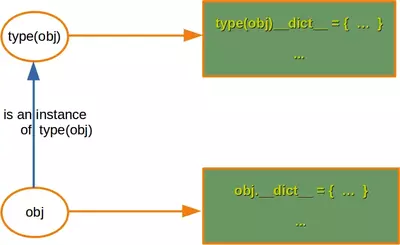

```obj.attr``` has a lookup chain starting with ```obj.__dict__['attr']```, i.e. that checks if ```obj.attr``` is a key of the dictionary ```obj.__dict__['attr']```.

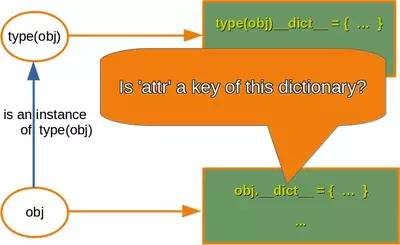

If ```attr``` is not a key of ```obj.__dict__```, it will try to lookup ```type(obj).__dict__['attr']```.

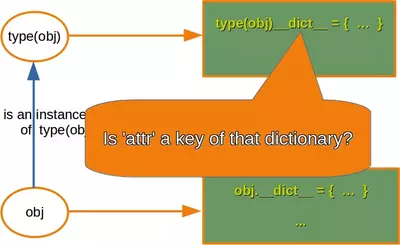

If ```attr``` is not contained in this dictionary either, it will continue checking through the base classes of ```type(obj)``` excluding metaclasses.

We demonstrate this in an example:

In [1]:
class A:
    ca_A = "class attribute of A"
    def __init__(self):
        self.ia_A = "instance attribute of A instance"
class B(A):
    ca_B = "class attribute of B"
    def __init__(self):
        super().__init__()
        self.ia_B = "instance attribute of B instance"
x = B()
print(x.ia_B)
print(x.ca_B)
print(x.ia_A)
print(x.ca_A)

instance attribute of B instance
class attribute of B
instance attribute of A instance
class attribute of A


If we call ```print(x.non_existing)``` we get the following exception:

In [2]:
print(x.non_existing)

AttributeError: 'B' object has no attribute 'non_existing'

If the looked-up value is an object defining one of the descriptor methods, then Python may override the default behavior and invoke the descriptor method instead. Where this occurs in the precedence chain depends on which descriptor methods were defined.

Descriptors provide a powerful, general purpose protocol, which is the underlying mechanism behind properties, methods, static methods, class methods, and super(). Descriptors were needed to implement the so-called new style classes introduced in version 2.2. The "new style classes" are the default nowadays.

## Descriptor Protocol
The general descriptor protocol consists of three methods:
```
descr.__get__(self, obj, type=None) -> value
descr.__set__(self, obj, value) -> None
descr.__delete__(self, obj) -> None
```

If you define one or more of these methods, you will create a descriptor. We distinguish between **data descriptors** and **non-data descriptors**:

**non-data descriptor**
- If we define only the ```__get__()``` method, we create a non-data descriptor, which are mostly used for methods.

**data descriptor**
- If an object defines ```__set__()``` or ```__delete__()```, it is considered a data descriptor.
- To make a read-only data descriptor, define both ```__get__()``` and ```__set__()``` with the ```__set__()``` raising an AttributeError when called.
- Defining the ```__set__()``` method with an exception raising placeholder is enough to make it a data descriptor.

We finally come now to our simple descriptor example in the following code:

In [3]:
class SimpleDescriptor(object):
    """
    A simple data descriptor that can set and return values
    """
    def __init__(self, initval=None):
        print("__init__ of SimpleDecorator called with initval: ", initval)
        self.__set__(self, initval)
    def __get__(self, instance, owner):
        print(instance, owner)
        print('Getting (Retrieving) self.val: ', self.val)
        return self.val
    def __set__(self, instance, value):
        print('Setting self.val to ', value)
        self.val = value
class MyClass(object):
    x = SimpleDescriptor("green")
m = MyClass()
print(m.x)
m.x = "yellow"
print(m.x)

__init__ of SimpleDecorator called with initval:  green
Setting self.val to  green
<__main__.MyClass object at 0x000001BD3499B518> <class '__main__.MyClass'>
Getting (Retrieving) self.val:  green
green
Setting self.val to  yellow
<__main__.MyClass object at 0x000001BD3499B518> <class '__main__.MyClass'>
Getting (Retrieving) self.val:  yellow
yellow


The third parameter owner of ```__get__``` is always the owner class and provides users with an option to do something with the class that was used to call the descriptor. Usually, i.e. if the descriptor is called through an object ```obj```, the object type can be deduced by calling ```type(obj)```. The situation is different if the descriptor is invoked through a class. In this case it is ```None``` and it wouldn't be possible to access the class unless the third argument is given. The second parameter instance is the instance that the attribute was accessed through, or ```None``` when the attribute is accessed through the owner.

Let's have a look at the ```__dict__``` dictionaries of both the instances and the class:

'x' is a class attribute in the previous class. You may have asked yourself if we could also use this mechanism in the ```__init__``` method to define instance attributes. This is not possible. The methods ```__get__()```, ```__set__()```, and ```__delete__()``` will only apply if an instance of the class containing the method (a so-called descriptor class) appears in an owner class (the descriptor must be in either the owner’s class dictionary or in the class dictionary for one of its parents). In the examples above, the attribute 'x' is in the owner ```__dict__``` of the owner class MyClass, as we can see below:

In [5]:
print(m.__dict__)

{}


In [6]:
print(MyClass.__dict__)

{'__module__': '__main__', 'x': <__main__.SimpleDescriptor object at 0x000001BD3499B4E0>, '__dict__': <attribute '__dict__' of 'MyClass' objects>, '__weakref__': <attribute '__weakref__' of 'MyClass' objects>, '__doc__': None}


In [7]:
print(SimpleDescriptor.__dict__)

{'__module__': '__main__', '__doc__': '\n    A simple data descriptor that can set and return values\n    ', '__init__': <function SimpleDescriptor.__init__ at 0x000001BD349888C8>, '__get__': <function SimpleDescriptor.__get__ at 0x000001BD34988950>, '__set__': <function SimpleDescriptor.__set__ at 0x000001BD349889D8>, '__dict__': <attribute '__dict__' of 'SimpleDescriptor' objects>, '__weakref__': <attribute '__weakref__' of 'SimpleDescriptor' objects>}


In [8]:
print(MyClass.__dict__['x'])

It is possible to call a descriptor directly by its method name, e.g. ```d.__get__(obj)```.

Alternatively, it is more common for a descriptor to be invoked automatically upon attribute access. For example, ```obj.d``` looks up ```d``` in the dictionary ```__dict__``` of ```obj```. If ```d``` defines the method ```__get__()```, then ```d.__get__(obj)``` is invoked according to the precedence rules listed below.

It makes a difference if ```obj``` is an **object** or a **class**:
- For objects, the method to control the invocation is in object.__getattribute__() which transforms b.x into the call type(b).__dict__['x'].__get__(b, type(b)). The implementation works through a precedence chain that gives data descriptors priority over instance variables, instance variables priority over non-data descriptors, and assigns lowest priority to __getattr__() if provided.
- For classes, the corresponding method is in the type class, i.e. type.__getattribute__() which transforms B.x into B.__dict__['x'].__get__(None, B).

```__getattribute__``` is not implemented in Python but in C. The following Python code is a simulation of the logic in Python. We can see that the descriptors are called by the ```__getattribute__``` implementations.

In [9]:
def __getattribute__(self, key):
    "Emulate type_getattro() in Objects/typeobject.c"
    v = type.__getattribute__(self, key)
    if hasattr(v, '__get__'):
        return v.__get__(None, self)
    return v
m.__getattribute__("x")

<__main__.MyClass object at 0x000001BD3499B518> <class '__main__.MyClass'>
Getting (Retrieving) self.val:  yellow


'yellow'

The object returned by ```super()``` also has a custom ```__getattribute__()``` method for invoking descriptors. The attribute lookup super(B, obj).m searches ```obj.__class__.__mro__``` for the base class A immediately following B and then returns ```A.__dict__['m'].__get__(obj, B)```. If not a descriptor, ```m``` is returned unchanged. If not in the dictionary, ```m``` reverts to a search using ```object.__getattribute__()```.

The details above show that the mechanism for descriptors is embedded in the ```__getattribute__()``` methods for object, type, and super(). Classes inherit this machinery when they derive from objects or if they have a meta-class providing similar functionality. This means also that one can turn-off automatic descriptor calls by overriding ```__getattribute__()```.

In [10]:
from weakref import WeakKeyDictionary
class Voter:
    required_age = 18 # in Germany
    def __init__(self):
        self.age = WeakKeyDictionary()
    def __get__(self, instance_obj, objtype):
        return self.age.get(instance_obj)
    def __set__(self, instance, new_age):
        if new_age < Voter.required_age:
            msg = '{name} is not old enough to vote in Germany'
            raise Exception(msg.format(name=instance.name))
        self.age[instance] = new_age
        print('{name} can vote in Germany'.format(
            name=instance.name))
    def __delete__(self, instance):
        del self.age[instance]
class Person:
    voter_age = Voter()
    def __init__(self, name, age):
        self.name = name
        self.voter_age = age
p1 = Person('Ben', 23)
p2 = Person('Emilia', 22)
p2.voter_age

Ben can vote in Germany
Emilia can vote in Germany


22

A pure sample implementation of a property() class from Python's Descriptor: (https://docs.python.org/3/howto/descriptor.html#properties)

In [11]:
class Property:
    "Emulate PyProperty_Type() in Objects/descrobject.c"
    def __init__(self, fget=None, fset=None, fdel=None, doc=None):
        self.fget = fget
        self.fset = fset
        self.fdel = fdel
        if doc is None and fget is not None:
            doc = fget.__doc__
        self.__doc__ = doc
    def __get__(self, obj, objtype=None):
        if obj is None:
            return self
        if self.fget is None:
            raise AttributeError("unreadable attribute")
        return self.fget(obj)
    def __set__(self, obj, value):
        if self.fset is None:
            raise AttributeError("can't set attribute")
        self.fset(obj, value)
    def __delete__(self, obj):
        if self.fdel is None:
            raise AttributeError("can't delete attribute")
        self.fdel(obj)
    def getter(self, fget):
        return type(self)(fget, self.fset, self.fdel, self.__doc__)
    def setter(self, fset):
        return type(self)(self.fget, fset, self.fdel, self.__doc__)
    def deleter(self, fdel):
        return type(self)(self.fget, self.fset, fdel, self.__doc__)

A simple class using our Property implementation:

In [12]:
class A:
    def __init__(self, prop):
        self.prop = prop
    @Property
    def prop(self):
        print("The Property 'prop' will be returned now:")
        return self.__prop
    @prop.setter
    def prop(self, prop):
        print("prop will be set")
        self.__prop = prop

Using our class A:

In [13]:
print("Initializing the Property 'prop' with the value 'Python'")
x = A("Python")
print("The value is: ", x.prop)
print("Reassigning the Property 'prop' to 'Python descriptors'")
x.prop = "Python descriptors"
print("The value is: ", x.prop)

Initializing the Property 'prop' with the value 'Python'
prop will be set
The Property 'prop' will be returned now:
The value is:  Python
Reassigning the Property 'prop' to 'Python descriptors'
prop will be set
The Property 'prop' will be returned now:
The value is:  Python descriptors


Let's make our Property implementation a little bit more talkative with some print functions to see what is going on:

In [14]:
class Property:
    "Emulate PyProperty_Type() in Objects/descrobject.c"
    def __init__(self, fget=None, fset=None, fdel=None, doc=None):
        print("\n__init__ of Property called with:")
        print("fget=" + str(fget) + " fset=" + str(fset) + \
              " fdel=" + str(fdel) + " doc=" + str(doc))
        self.fget = fget
        self.fset = fset
        self.fdel = fdel
        if doc is None and fget is not None:
            doc = fget.__doc__
        self.__doc__ = doc
    def __get__(self, obj, objtype=None):
        print("\nProperty.__get__ has been called!")
        if obj is None:
            return self
        if self.fget is None:
            raise AttributeError("unreadable attribute")
        return self.fget(obj)
    def __set__(self, obj, value):
        print("\nProperty.__set__ has been called!")
        if self.fset is None:
            raise AttributeError("can't set attribute")
        self.fset(obj, value)
    def __delete__(self, obj):
        print("\nProperty.__delete__ has been called!")
        if self.fdel is None:
            raise AttributeError("can't delete attribute")
        self.fdel(obj)
    def getter(self, fget):
        print("\nProperty.getter has been called!")
        return type(self)(fget, self.fset, self.fdel, self.__doc__)
    def setter(self, fset):
        print("\nProperty.setter has been called!")
        return type(self)(self.fget, fset, self.fdel, self.__doc__)
    def deleter(self, fdel):
        print("\nProperty.deleter has been called!")
        return type(self)(self.fget, self.fset, fdel, self.__doc__)
class A:
    def __init__(self, prop):
        self.prop = prop
    @Property
    def prop(self):
        """ This will be the doc string of the property """
        print("The Property 'prop' will be returned now:")
        return self.__prop
    @prop.setter
    def prop(self, prop):
        print("prop will be set")
        self.__prop = prop
    def prop2_getter(self):
        return self.__prop2
    def prop2_setter(self, prop2):
        self.__prop2 = prop2
    prop2 = Property(prop2_getter, prop2_setter)
print("Initializing the Property 'prop' with the value 'Python'")
x = A("Python")
print("The value is: ", x.prop)
print("Reassigning the Property 'prop' to 'Python descriptors'")
x.prop = "Python descriptors"
print("The value is: ", x.prop)
print(A.prop.getter(x))
def new_prop_setter(self, prop):
    if prop=="foo":
        self.__prop = "foobar"
    else:
        self.__prop = prop
A.prop.setter


__init__ of Property called with:
fget=<function A.prop at 0x000001BD349ACAE8> fset=None fdel=None doc=None

Property.setter has been called!

__init__ of Property called with:
fget=<function A.prop at 0x000001BD349ACAE8> fset=<function A.prop at 0x000001BD349AC7B8> fdel=None doc= This will be the doc string of the property 

__init__ of Property called with:
fget=<function A.prop2_getter at 0x000001BD349ACEA0> fset=<function A.prop2_setter at 0x000001BD349ACF28> fdel=None doc=None
Initializing the Property 'prop' with the value 'Python'

Property.__set__ has been called!
prop will be set

Property.__get__ has been called!
The Property 'prop' will be returned now:
The value is:  Python
Reassigning the Property 'prop' to 'Python descriptors'

Property.__set__ has been called!
prop will be set

Property.__get__ has been called!
The Property 'prop' will be returned now:
The value is:  Python descriptors

Property.__get__ has been called!

Property.getter has been called!

__init__ of Pro

<bound method Property.setter of <__main__.Property object at 0x000001BD348C1470>>

In [15]:
class Robot:
    def __init__(self, name="Marvin", city="Freiburg"):
        self.name = name
        self.city = city
    @Property
    def name(self):
        return self.__name
    @name.setter
    def name(self, name):
        if name == "hello":
            self.__name = "hi"
        else:
            self.__name = name
x = Robot("Marvin")
print(x.name)
x.name = "Eddie"
print(x.name)


__init__ of Property called with:
fget=<function Robot.name at 0x000001BD349AC9D8> fset=None fdel=None doc=None

Property.setter has been called!

__init__ of Property called with:
fget=<function Robot.name at 0x000001BD349AC9D8> fset=<function Robot.name at 0x000001BD349D60D0> fdel=None doc=None

Property.__set__ has been called!

Property.__get__ has been called!
Marvin

Property.__set__ has been called!

Property.__get__ has been called!
Eddie


In [16]:
class A:
    def a(func):
        def helper(self, x):
            return 4 * func(self, x)
        return helper
    @a
    def b(self, x):
        return x + 1
a = A()
a.b(4)

20

A lot of people ask, if it is possible to automatically create descriptors at runtime. This is possible as we show in the following example. On the other hand, this example is not very useful, because the getters and setters have no real functionality:

In [17]:
class DynPropertyClass(object):
    def add_property(self, attribute):
        """ add a property to the class """        
        def get_attribute(self):
            """ The value for attribute 'attribute' will be retrieved """
            return getattr(self, "_" + type(x).__name__ + "__" + attribute)
        def set_attribute(self, value):
            """ The value for attribute 'attribute' will be retrieved """
            #setter = lambda self, value: self.setProperty(attribute, value)
            setattr(self, "_" + type(x).__name__ + "__" + attribute, value)
        #construct property attribute and add it to the class
        setattr(type(self), attribute, property(fget=get_attribute, 
                                                fset=set_attribute, 
                                                doc="Auto‑generated method"))
x = DynPropertyClass()
x.add_property('name')
x.add_property('city')
x.name = "Henry"
x.name
x.city = "Hamburg"
print(x.name, x.city)
print(x.__dict__)

Henry Hamburg
{'_DynPropertyClass__name': 'Henry', '_DynPropertyClass__city': 'Hamburg'}
